# Custom wind speed and sig profiles

This example shows how you can create your own functions for the wind speed and turbulence standard deviation as a function of spatial location. For simplicity, we will keep the default Kaimal spectrum, but you could also have the spectrum be a custom function as well.

The spatial variation of the mean wind speed and turbulence standard deviation we choose in this example will be to mimic a full-wake scenario. Note that these variables are not necessarily physically realistic, this is just a demonstration!

This example has the following sections:  

* [Preliminaries](#Preliminaries:-importing-functions)  

* [Defining grid and time step](#Define-turbulence-grid-and-time)  

* [Custom wind speed profile](#Custom-wind-speed-profile)  

* [Custom turbulence std dev](#Custom-turbulence-standard-deviation-profile)  

* [Generate and inspect turbulence](#Generate-and-inspect-turbulence)  

**Note**: it is also possible to have a custom power spectrum profile function, but that is not explicitly demonstrated here. However, the method is extremely similar to what is shown here, and more information can be found in the related tab under the Reference Guide.

## Preliminaries: importing functions

Before we can begin, we need to importe a few functions and define some variables that we will need later.

In [1]:
%matplotlib inline
#import os

import matplotlib.pyplot as plt  # matplotlib for some plotting
import numpy as np  # numeric python functions

from pyconturb import gen_turb, gen_spat_grid  # generate turbulence, rect. grid
from pyconturb.wind_profiles import constant_profile  # useful for freestream

cntr_pos, rad, u_inf = [0, 119], 90, 12  # center pos of grid, radius of "wake", and inflow wsp

## Define turbulence grid and time

Our first step is to define 1) the simulation time/time step and 2) the points of the grid and which turbulence components (i.e., $u$, $v$ and/or $w$) we want to simulate. For this example, we'll pick a fairly dense grid, but we'll only simulate the longitudinal component.

   u_p0       u_p1       u_p2       u_p3       u_p4       u_p5        u_p6  \
k   0.0   0.000000   0.000000   0.000000   0.000000   0.000000    0.000000   
x   0.0   0.000000   0.000000   0.000000   0.000000   0.000000    0.000000   
y -90.0 -90.000000 -90.000000 -90.000000 -90.000000 -90.000000  -90.000000   
z  29.0  41.857143  54.714286  67.571429  80.428571  93.285714  106.142857   

    u_p7        u_p8        u_p9  ...     u_p215      u_p216  u_p217  \
k    0.0    0.000000    0.000000  ...   0.000000    0.000000     0.0   
x    0.0    0.000000    0.000000  ...   0.000000    0.000000     0.0   
y  -90.0  -90.000000  -90.000000  ...  90.000000   90.000000    90.0   
z  119.0  131.857143  144.714286  ...  93.285714  106.142857   119.0   

       u_p218      u_p219      u_p220      u_p221      u_p222      u_p223  \
k    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
x    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
y   90.000000   9

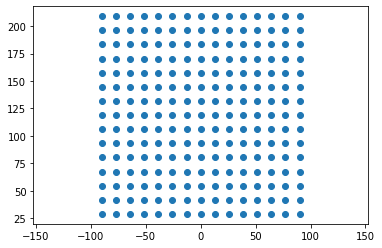

In [2]:
T, nt = 300, 300  # only simulate 300 seconds for now
y, z = np.linspace(-rad, rad, 15), np.linspace(cntr_pos[1] - rad, cntr_pos[1] + rad, 15)
spat_df = gen_spat_grid(y, z, comps=[0])  # generate grid with only u
print(spat_df.head())  # show a few columns of the spatial dataframe
print('No. of points to simulate: ', spat_df.shape[0])  # number of points to simulate
plt.scatter(spat_df.loc['y'], spat_df.loc['z'])  # show the grid
plt.axis('equal');

## Custom wind speed profile

Now let's define our custom functions for the spatial variation of the mean wind speed. Note that the wind speed function must be of the form
```
wsp_values = wsp_func(spat_df, **kwargs)
```
where `kwargs` is a dictionary of the keyword arguments for the profile function. (It can also include unused keyword arguments.)

In [3]:
def wake_wsp(spat_df, cntr_pos=[0, 90], rad=50, u_inf=10, max_def=0.5, **kwargs):
    """Non-realistic wake deficit.
    rad is the wake of the wake, u_inf is undisturbed inflow, and max_def is the max. deficit."""
    y, z = spat_df.loc[['y', 'z']].values
    dist_to_cntr = np.sqrt((y - cntr_pos[0])**2 + (z - cntr_pos[1])**2)  # distance to center point
    freestream = constant_profile(spat_df, u_ref=u_inf)  # no wake deficit
    wake_def = max_def * np.sin(np.pi/2 * (rad - dist_to_cntr) / rad)  # sinusoidal
    wake_def = wake_def * (dist_to_cntr < rad)  # deficit is not outside of rad
    return np.array(freestream - wake_def)  # must return array regardless of input

We can plot a few different waked profiles to check that this function works.

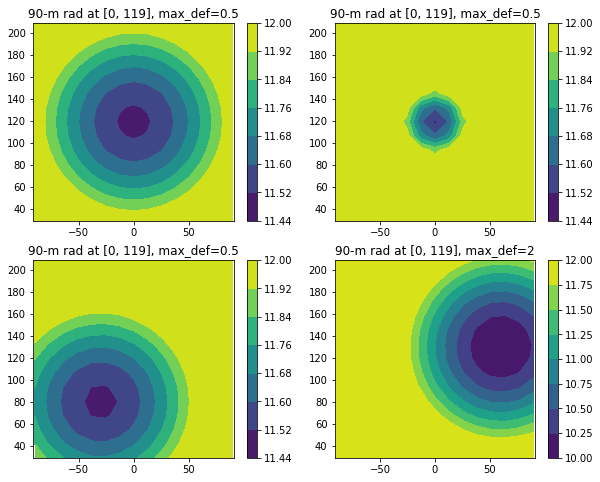

In [4]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9.9, 8))
plot_vals = [([0, 119], 90, 0.5), ([0, 119], 30, 0.5), ([-30, 80], 90, 0.5), ([60, 130], 90, 2)]
for iax, (cnt, r, mdef) in enumerate(plot_vals):
    ax = axs[iax//2, iax%2]
    wsp_values = wake_wsp(spat_df, cntr_pos=cnt, rad=r, u_inf=u_inf, max_def=mdef)
    cnt = ax.contourf(y, z, wsp_values.reshape(y.size, z.size).T)
    ax.axis('equal')
    plt.colorbar(cnt, ax=ax);
    ax.set_title(f'{rad}-m rad at {cntr_pos}, max_def={mdef}')

## Custom turbulence standard deviation profile

Just like we did for the mean wind speed, now let us define a function for the turbulence standard deviation as a function of spatial location (and turbulence component). Note that the sig function must be of the form
```
sig_values = sig_func(spat_df, **kwargs)
```
where `kwargs` is a dictionary of the keyword arguments for the profile function. (It can also include unused keyword arguments.)

In [5]:
def wake_sig(spat_df, cntr_pos=[0, 90], rad=50, sig_inf=1.2, max_perc=0.20, **kwargs):
    """Non-realistic wake turbulence. sig_inf is the undisturbed standard deviation and max_perc is the
    maximum percentage increase of sigma at the center."""
    y, z = spat_df.loc[['y', 'z']].values
    dist_to_cntr = np.sqrt((y - cntr_pos[0])**2 + (z - cntr_pos[1])**2)  # distance to center point
    mask = (dist_to_cntr < rad)  # points that fall within the wake
    wake_sig = sig_inf * constant_profile(spat_df, u_ref=1)  # freestream sig
    wake_sig[mask] += max_perc*sig_inf * np.sin(np.pi/2 * (rad - dist_to_cntr[mask]) / rad)
    return np.array(wake_sig)  # must return array regardless of input

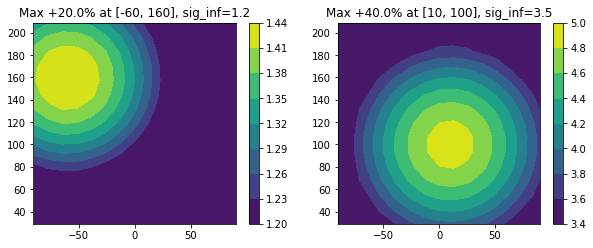

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.7))
plot_vals = [([-60, 160], 1.2, 0.2), ([10, 100], 3.5, 0.4)]
for iax, (cntr, sig, mperc) in enumerate(plot_vals):
    ax = axs[iax]
    sig_values = wake_sig(spat_df, cntr_pos=cntr, rad=rad, sig_inf=sig,
                          max_perc=mperc)
    cnt = ax.contourf(y, z, sig_values.reshape(y.size, z.size).T)
    ax.axis('equal')
    plt.colorbar(cnt, ax=ax);
    ax.set_title(f'Max +{mperc*100}% at {cntr}, sig_inf={sig}')

## Generate and inspect turbulence

Now that we've created (and verified) our custom wind speed and turbulence standard deviation functions, we can run our turbulence generation. We first put all of our simulation options into a keyword argument dictionary and then pass those into `gen_turb`. Note that `u_ref` is no longer used in the wind speed or sig profiles, but it is needed for the Kaimal spectrum function.

In [7]:
kwargs = {'T': T, 'nt': nt, 'u_ref': 10, 'wsp_func': wake_wsp, 'sig_func': wake_sig,
          'cntr_pos': cntr_pos, 'rad': rad, 'u_inf': u_inf, 'sig_inf': 1, 'max_perc': 2}
turb_df = gen_turb(spat_df, **kwargs)

We can inspect the resulting turbulence block to see if it matches our expectations.

**Size/elements:**

In [8]:
turb_df.head()

,u_p0,u_p1,u_p2,u_p3,u_p4,u_p5,u_p6,u_p7,u_p8,u_p9,...,u_p215,u_p216,u_p217,u_p218,u_p219,u_p220,u_p221,u_p222,u_p223,u_p224
0.0,12.103620,11.628982,12.426398,12.568169,11.754686,11.869765,12.294438,11.545071,10.396311,11.103300,...,11.282843,11.391541,11.745385,11.814297,10.426066,10.717269,11.262871,10.320009,10.327251,10.439028
1.0,12.190487,11.851249,12.191917,12.548995,11.660339,11.910316,12.402404,11.474261,11.089096,10.964456,...,11.792169,11.406766,11.825803,11.048680,10.487106,10.172399,10.515647,10.647027,10.485603,10.880167
2.0,12.370982,11.927082,12.583363,12.862673,12.039248,12.803614,12.584276,11.475617,12.066624,11.290379,...,11.984070,11.901769,11.572587,11.275840,10.639433,10.715023,10.635616,11.437412,10.182981,10.408200
3.0,12.858970,12.538112,12.683886,12.300829,12.115459,12.607563,12.976577,11.958170,11.412074,11.781461,...,11.619407,11.889740,11.764894,11.947882,11.333286,10.391484,11.520560,11.085389,10.714025,9.799436
4.0,12.483053,12.442919,12.154956,12.021817,11.566429,12.079849,12.443258,11.994063,11.345704,10.742336,...,11.540103,12.575407,11.910604,12.262222,11.402146,10.839567,11.212864,11.371674,10.173282,9.778668


**Mean wind speed profile:**

Min mwsp:  11.500000000000004   Max mwsp:  12.00000000000001


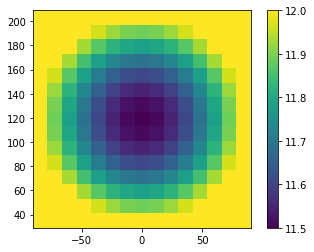

In [9]:
mean_wsp = turb_df.mean().values
print('Min mwsp: ', mean_wsp.min(), '  Max mwsp: ', mean_wsp.max())

plt.imshow(np.reshape(mean_wsp, (y.size, z.size)).T, interpolation='none',
           origin='lower', extent=[y.min(), y.max(), z.min(), z.max()])
plt.colorbar();

This looks exactly as we expect it to: the mean wind speed outside the waked area is 12 m/s, and the maximum deficit is 0.5 m/s. Excellent.

**Turbulence standard deviation:**

Min std:  0.7213599305096582   Max std:  3.2727737388977096


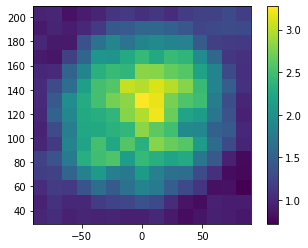

In [10]:
std_wsp = turb_df.std().values
print('Min std: ', std_wsp.min(), '  Max std: ', std_wsp.max())

plt.imshow(np.reshape(std_wsp, (y.size, z.size)).T, interpolation='none',
           origin='lower', extent=[y.min(), y.max(), z.min(), z.max()])
plt.colorbar();

As you can see, there is more variation in the turbulence profile. This is due to the spatial correlation procedure that occurs during the Veers method simulation; we will never get the exact TI profile we specify. However, we still generally get the correct values: 1.0 m/s in the freestream and 3.0 (200% higher) at the highest.